In [ ]:
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet
import nltk
from nltk import pos_tag


import gensim
import re
import spacy

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import json
import pandas as pd
import numpy as np

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Data loading

In [ ]:
df_train = pd.read_json('project_training.json')
df_test = pd.read_json('project_validation.json')



### Define preprocessing steps

In [ ]:
from functools import partial

nltk_stopwords = set(stopwords.words("english"))

gensim_stopwords = gensim.parsing.preprocessing.STOPWORDS


wordnet_lemmatizer = WordNetLemmatizer()
snow_stemmer = SnowballStemmer(language='english')

# filters: which words are filtered/ removed (e.g. stopwords)
# mappers: for switching the words (e.g. lower-case)
def preprocessor_fn(text, tokenizer=RegexpTokenizer(r'\w+'), filters=None, mappers=None):
    words = tokenizer.tokenize(text)
    if filters:
        for f in filters:
            words = [word for word in words if f(word)]
    if mappers:
        for f in mappers:
            words = [f(word) for word in words]
    return ' '.join(words)

In [ ]:
preprocessors = {
    'baseline': partial(preprocessor_fn),
    'lowercase': partial(preprocessor_fn, mappers=[lambda x: x.lower()]),
    'nltk_stopwords': partial(preprocessor_fn, filters=[lambda x: x not in nltk_stopwords]),
    'gensim_stopwords': partial(preprocessor_fn, filters=[lambda x: x not in gensim_stopwords]),
    'snow_stemmer': partial(preprocessor_fn, mappers=[snow_stemmer.stem]),
    'wordnet_lemmatizer': partial(preprocessor_fn, mappers=[wordnet_lemmatizer.lemmatize]),
}

### Define rule-based classifier

In [ ]:
from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
import random
from copy import deepcopy


class RuleBasedClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self, estimators, thresholds=None, preprocessor=None):
        self.n_classes = len(estimators)
        if thresholds is None:
            self.thresholds = np.zeros(self.n_classes, dtype=float)
        else:
            self.thresholds = thresholds
        self.labels = list(estimators.keys())
        self.estimators = estimators
        self.preprocessor = preprocessor

    def get_params(self, deep=True):
        return {
              'thresholds': self.thresholds,
              'preprocessor': self.preprocessor,
              'estimators': self.estimators,
          }

    def fit(self, X, y, **kwargs):
        if y is None:
            raise ValueError('requires y to be passed, but the target y is None')

        self.classes_ = unique_labels(y)
        self.is_fitted_ = True
        self.n_features_in_ = 0
        
        assert len(self.classes_) == self.n_classes
        
        return self

    def predict(self, X):
        check_is_fitted(self, ['is_fitted_'])
        labels = []
        for x in X:
            passed = []
            processed_text = self.preprocessor(x)
            num_words = len(processed_text.split(' '))
            # Loops through each label-estimator pair in the estimators dictionary of the class instance.
            if self.n_classes == 2:
                # perform binary classification
                for i, (label, estimator) in enumerate(self.estimators.items()):
                    score = estimator.estimate(processed_text)
                    normalized_score = score / num_words
                    if normalized_score >= self.thresholds[i]:
                        passed.append(label)
                if len(passed) == 0:
                    # none of them passed the threshold
                    labels.append(random.choice(self.labels))
                else:
                    labels.append(passed[0])
            else:
                # perform multi-class classification
                for i, (label, estimator) in enumerate(self.estimators.items()):
                    score = estimator.estimate(processed_text)
                    normalized_score = score / num_words
                    if normalized_score >= self.thresholds[i]:
                        passed.append((label, score))
                if len(passed) == 0:
                    # none of them passed the threshold
                    labels.append(random.choice(self.labels))
                else:
                    passed.sort(key=lambda p: p[1], reverse=True)
                    labels.append(passed[0][0])
        return np.array(labels)




In [ ]:
class Estimator:
    def estimate(self, text):
        pass

In [ ]:
climate_words = ['climate', 'warming', 'weather', 'greenhouse', 'gas', 'warming', 'carbon', 'dioxide', 'fossil', 'fuels', 
'renewable', 'energy', 'footprint', 'sustainable', 'ecosystem', 'extinction', 'adaptation', 'mitigation', 'emission', 'ozone',
'deforestation', 'melting', 'ice', 'biodiversity', 'pollution', 'crisis', 'IPCC', 'risk', 'governance', 'index', 'environmental',
'social', 'water', 'waste', 'energy', 'electricity', 'coal', 'fuel', 'CO2', 'deforestation', 'ecological', 'pollutant', 'viability',
'temperature', 'humidity', 'atmospheric', 'wind', 'precipitation', 'hydrosphere', 'cryosphere', 'trend', 'atmospheric', 'altitude',
'ocean', 'mountain', 'basins', 'redistribute', 'heat', 'solar', 'absorption', 'retention', 'rainfall', 'retain', 'cool', 'latitude', 
'hardiness', 'evapotranspiration', 'raw', 'material', 'recyclable', 'storm', 'flood', 'draught', 'wood', 'harvest', 'WRI', 'WWF', 
'IMO', 'catastrophe', 'pandemic', 'hurricane', 'tornado', 'wildfires', 'windstorms', 'disasters', 'ESG', 'multidisciplinary', 
'IAG', 'supply', 'landslips', 'resources', 'Paleoclimatology', 'earth', 'tree', 'sediments', 'pollen', 'coral', 'rocks', 'thermometers',
'barometers', 'anemometers', 'population', 'Arctic', 'spatial', 'temporal', 'oscillations', 'astronomical', 'cloud', 'global', 'regional',
'sunlight', 'sun', 'investment', 'impact', 'project', 'sector', 'activity', 'scenario', 'technology', 'industry', 'event', 'related', 
'transition', 'target', 'fund', 'oil', 'generate', 'scope', 'level', 'system', 'action', 'factor', 'infrastructure', 'demage', 'effect', 
'efficiency', 'resilient', 'extreme', 'community', 'transport', 'index', 'launch', 'severity', 'interaction', 'balance', 'wave', 
'electromagnetic', 'radiation', 'surface', 'microclimate', 'EO2','hit', 'Antarctica', 'sea', 'Cyclone', 'Snow', 'biodiversity',
'OPEC', 'COP27', 'safe', 'planetary', 'atmosphere', 'accelerate', 'melting', 'Celsius', 'catastrophic', 'physical', 'chemical', 'biological',
'fertilized', 'permafrost', 'thawing', 'forest', 'destruction', 'soil', 'smoldering', 'peatlands', 'Arctic', 'area', 'dwindling', 'disintegration',
'cliff', 'projection', 'mobilization', 'impact', 'EOS', 'inorganic', 'framework', 'dynamic', 'evolution', 'ecology', 'biogeochemistry', 'process',
 'consumption', 'source', 'stock', 'UNFCCC', 'GHGs', 'trajectory', 'extrapolating', 'IEA','supply', 'eradicate', 'development', 'industrial', 
 'anthropogenic', 'region', 'season', 'millennia', 'acidification', 'peak', 'duration', 'pathway', 'radiative', 'tropics', 'island', 'coastal', 
 'deltas', 'saltwater', 'intrusion', 'reinforcement', 'extinction', 'invasive', 'species', 'woody', 'degradation', 'encroaching', 'oxygen', 
 'fisheries', 'reef', 'aquaculture', 'physiology', 'survivorship', 'habitat', 'reproduction', 'disease', 'incidence', 'health', 'livelihood', 
 'security', 'food', 'Population', 'disproportionately', 'indigenous', 'agricultural', 'dryland', 'borne', 'malaria', 'dengue', 'maize', 'rice',
 'cereal', 'spread','feed', 'mitigation', 'adaptation', 'subtropics', 'spatially', 'exacerbating', 'hazards','decarbonization', 'bioenergy', 
 'nitrous', 'methane', 'wetland', 'ethic', 'feasibility', 'generation', 'bio', 'institutional', 'asset', 'pasture', 'crops', 'livestock', 
 'fibre', 'services', 'reforestation', 'afforestation', 'restoration', 'effectiveness', 'geophysical', 'rain', 'ecological', 'natura', 'rural', 
 'poverty', 'biomass', 'diet', 'sequestration', 'manure', 'circumstance', 'capability', 'pursuit', 'GMST', 'geological', 'terrestrial', 'reservoir',
  'product', 'overshoot', 'cultural', 'economic', 'volume', 'ecologists', 'animal', 'respiration', 'growth', 'plant', 'phenology', 'microevolutionary',
  'cold', 'distribution', 'warm', 'IPCC', 'change' ,'effluent', 'hazardous', 'disposal', 'diversity','drought','Farm', 'microgrid', 'protect',
  'Construction', 'green', 'steam', 'power', 'recycling', 'reuse', 'electrify', 'transport', 'Transmission', 'mechanisms', 'natural','clinker',
  'mineral', 'pozzolan', 'slag', 'ash', 'cement', 'Community', 'globe', 'Hydrogen', 'lifespan', 'offshore','onshore','electrification',
  'consolidation', 'grid', 'hydro','vehicles', 'mobility', 'engines','commercial','passenger','battery','produce','sugars', 'filling','pipeline',
  'oilfields', 'drilling', 'oil', 'cogeneration', 'road', 'domestic', 'regional', 'policy', 'Agriculture', 'cultivated', 'waves','tropical',
  'surge','tide', 'spring', 'exploration', 'extraction', 'transportation', 'sands', 'exploit', 'petroleum', 'vessels', 'rail', 'refineries',
  'fire', 'pests','diseases', 'patterns', 'photovoltaic', 'desalination', 'surface', 'illness', 'Upstream', 'decarbonise', 'residential',
  'commercial', 'extractive', 'warehousing', 'torrential', 'unseasonable', 'composting', 'fleet', 'mines', 'landscape', 'localised',
  'hectares', 'desertification', 'salinisation', 'earthquake', 'outages', 'property', 'chemicals', 'thermal', 'humidity', 'fluctuations',
  'Commodities', 'inland', 'landowners', 'freight', 'typhoons', 'consuming', 'planet', 'urbanized', 'traffic', 'housing', 'air', 'market',
  'bush', 'sulfur', 'oxide', 'nitrogen', 'include', 'manage','ebbtide', 'ebb', 'tempest', 'ramp','inundation', 'deluge', 'alluvion','torrent',
  'twister', 'flowage', 'landslide', 'faulting', 'geological','urban', 'nondevelopment', 'hotness', 'ripe', 'powerlessness', 'downstream',
  'downriver', 'nonthermal','affectionate', 'tender', 'strong', 'ardent', 'conditions', 'upwind', 'gasoline', 'petrol', 'flatulence',
'throttle', 'regenerate', 'reincarnate', 'step', 'prolong', 'nourish', 'nurture', 'thaw','dissolve', 'unfreeze', 'unthaw', 'dethaw',
'frosting', 'ston', 'deposit', 'ground', 'lavatory', 'cinder', 'jet', 'leafy', 'vegetable', 'drouth', 'lake', 'pelting', 'pasture', 'graze',
'nitric', 'azotic', 'aboriginal', 'aborigine', 'produce', 'sprout','germinate'] 

sentiment_risk_words = ['risk', 'hazard', 'distort', 'unpredictable', 'cost', 'influence', 'exceptional', 'severe','storm',
                        'flood', 'draught', 'harvesting', 'impact', 'damage', 'loss', 'challenge', 'uncertainty', 'affect', 
                        'loan', 'adverse', 'catastrophe', 'failure', 'threat', 'disadvantage', 'lack', 'adversely', 
                        'extreme', 'catastrophic', 'existential', 'acute', 'disaster', 'hurricane', 'windstorm', 'wildfire',
                        'criticism', 'tax', 'opposite', 'catastrophe', 'frequency', 'severity', 'pandemic', 'tornadoes', 
                        'exposure', 'disruption', 'precipitation', 'landslip', 'few', 'pollution', 'waste', 'restrained', 'harden'
                        'Inequality', 'struggle', 'pay', 'problem', 'overlapping', 'poorly', 'opposed', 'badly', 'breaking',
                        'unable', 'shortage', 'paralysis', 'pollution', 'worsen', 'inadequate', 'uncertain', 'illness', 
                        'absenteeism', 'debt', 'momentum', 'heatwave', 'typhoon', 'rainfall', 'crisis', 'bleaching', 'less', 
                        'heavy', 'drought', 'downs', 'drainage', 'unplanned', 'interruptions', 'trauma', 'serious', 'expenditure',
                        'anxiety', 'insufficient', 'unclear', 'waves', 'heat', 'tropical','cyclones','interrupting', 'vulnerable', 
                        'effect', 'surge', 'tide', 'reduction', 'Limited', 'unsuccessful', 'affected', 'intensifies', 'unwilling', 
                        'compromised', 'changing', 'fall', 'compelled', 'stressors', 'limitations', 'fire','pests', 'diseases',
                        'understate', 'underwriting', 'desalination', 'lower', 'surface', 'frequent', 'heavy', 'illness','decline',
                        'activism', 'obsolete', 'unusable', 'disruption', 'downstream', 'abnormal', 'unseasonable', 'few', 'conventional',
                        'impairment', 'sensitive', 'restricts', 'divested', 'stretching','shrinking', 'desertification', 'deforestation',
                        'pollution', 'salinisation', 'deteriorate', 'provoke', 'earthquake', 'unemployment', 'pressures', 'deterioration', 
                        'drastically', 'outages', 'harm', 'scarcity', 'negatively', 'property', 'penalties', 'fines', 'dilemma', 'stress',
                        'against', 'poorly', 'unpredictability', 'unforeseen', 'prolonged', 'heavier', 'humidity', 'heightened', 
                        'breaking', 'destructive', 'stronger', 'exposed', 'strain', 'catastrophe', 'negative', 'not', 'difficult', 'litigation',
                        'trigger', 'Unfortunately', 'tripled', 'exposure', 'Fluctuations', 'no', 'paralysis', 'worsen', 'underappreciated',
                        'skeptical', 'devastating', 'bush', 'inaccurate', 'borrow','boycott','weak', 'jeopardy', 'peril', 'endangerment', 
                      'danger', 'gamble', 'adventure', 'venture', 'pretend', 'stake', 'jeopardize', 'falsify', 'garble', 'warp', 'twist', 'demur',
                       'exclude', 'violent', 'tempest', 'rage', 'force', 'inundation', 'deluge', 'alluvion', 'torrent','overflow', 'outpouring',
                        'impingement', 'encroachment', 'shock', 'bear', 'deprivation','feign', 'sham', 'dissemble', 'strike', 'loanword', 'lend',
                        'menace', 'terror', 'scourge', 'deficiency', 'taxation', 'twister','crack', 'interrupt', 'restrict', 'confine', 'hold', 
                        'encumber', 'cumber','constrain', 'intimidate', 'trouble', 'fault', 'faulting','shift', 'fracture', 'rupture', 'breach', 
                        'severance', 'rift', 'breakage', 'pause','disruption', 'gap', 'breakout', 'separate', 'decline', 'unsure','ailment', 'complaint',
                        'impulse','suspension']

sentiment_oppo_words =['collaboration', 'continue', 'investing', 'support', 'efforts', 'developed', 'able', 
                       'encouraging', 'resolve', 'help', 'strategy', 'aims', 'provide','provides', 'approved', 
                       'building', 'offer', 'recovering', 'improve', 'expansion', 'launched', 'discussions', 'believe', 
                       'opportunities', 'action', 'strengthen', 'ongoing', 'objectives', 'contribute', 'efficiencies', 
                       'prepared', 'proposals', 'initiative', 'sustain', 'development', 'develop', 'commit', 'product', 
                       'generate', 'work', 'increase', 'infrastructure', 'improve' , 'effort', 'accelerate', 'cut', 'new', 
                       'innovative', 'achieve', 'believe', 'target' ,'actively', 'launched', 'enhance', 'renewable',
                       'completed', 'set', 'green', 'promote', 'clean', 'renewable', 'Aiming', 'facilitate', 'creation', 'expected',
                       'better', 'prepare', 'adapt', 'investing', 'strategy', 'purchased', 'active', 'offsetting', 'leading', 
                       'plans', 'efficient', 'investment', 'Participating', 'scheme', 'pledged', 'additional', 'finance', 'address',
                       'consistent', 'implementation', 'installed', 'recovering', 'solutions', 'offer', 'consideration', 'design', 
                       'align','objective', 'value',  'place', 'emphasis', 'improving', 'performance', 'ongoing', 'responsible', 
                       'operation', 'issuance', 'eligible', 'acquisition', 'Framework', 'benefit','dedicated', 'responsible', 
                       'procurement', 'preventing', 'contribution', 'instruments', 'business', 'assistance', 'launch', 'commercial',
                       'compensation', 'solution', 'alternative', 'drive', 'transformation', 'ambitions', 'flexible', 'demand',
                       'generation', 'registered', 'built', 'stages', 'created', 'rebalances', 'return', 'applied','positively', 
                       'Revenues', 'protection','safety', 'available', 'ensuring', 'strengthening', 'expand', 'training', 'further',
                       'embedded', 'already', 'efficient', 'activities', 'make', 'commitment', 'Resources', 'spread', 'projects', 
                       'extended', 'education', 'protect', 'issues', 'partnership', 'perfect', 'quickly', 'respond', 'changes', 
                       'growth', 'stability', 'operated', 'measures', 'digitalization', 'rolled', 'Construction', 'awareness',
                       'encourage', 'adoption', 'campaigns', 'add', 'capable', 'add', 'enterprise', 'organisations', 'counselling', 
                        'maintained', 'schemes','phase', 'Agreement', 'spurring', 'transition', 'value', 'engaging', 'enabling', 
                        'stewardship', 'Systematically', 'customer', 'capacity', 'production', 'Save', 'recycling', 'recovery', 
                       'reuse', 'entered', 'new', 'mechanism', 'awarded', 'star', 'knowledge', 'join', 'future', 'resolve', 
                       'established', 'collaborative', 'outlined', 'Report', 'initiatives', 'accelerate', 'clean', 'viable',
                       'optimal', 'flexibility', 'adaptability', 'identify', 'together', 'great', 'action', 'combat',
                       'improvements', 'allocated','advance','finance', 'Goal', 'formed', 'leverage','focus','undertook','reliability',
                       'installations', 'boost','concrete', 'conclusive', 'Advancements','robust', 'digitalized','connected', 'evaluated',
                       'possible', 'scheduled','gain','achievements', 'regularly', 'considerable', 'friendly', 'invested', 'replaces', 
                       'cogeneration', 'attractive', 'include', 'mobilisation', 'empower ', 'access', 'tools', 'remain', 'forefront',
                       'policy', 'mobilize', 'process', 'key', 'incentivize','retrofit', 'healthier', 'happier', 'correct', 'good', 
                       'repair', 'certain', 'sure', 'well', 'goodness', 'derestrict','blueprint','put', 'reinforcement', 'reenforcement'
                       ,'livelihood', 'living', 'sustenance', 'accompaniment', 'funding', 'backing', 'endorse', 'indorse', 'plump',
                        'confirm', 'corroborate', 'substantiate', 'affirm', 'attempt', 'endeavor', 'try','exploit', 'campaign', 'movement',
                        'evolve', 'acquire', 'grow', 'produce', 'get', 'originate', 'arise', 'rise', 'uprise', 'explicate', 'formulate', 
                       'train', 'prepare', 'educate', 'modernize', 'nourish', 'consecrate', 'devote', 'institutionalise', 'entrust',
                       'merchandise','initiation', 'founding', 'institution', 'innovation', 'instauration', 'universe', 'anticipate', 
                       'gestate', 'accommodate','adjust', 'conform','lede','program', 'strategy', 'outline', 'destination', 'comprise',
                       'enforce','attend','yield','proceeds','cultivate', 'foster','widen', 'externalize','broaden','contract', 'encouragement',
                       'enceinte', 'expectant', 'honour','grant','fixing','mending']


spec_words = ['Hero', 'Santander', 'MUFG', 'IDB', 'C2F', 'Livorno', 'Plasmix', 'REDD', 'would', 'interventions', 
              'Kenya', 'invest',  'million', 'fund', 'renew', 'billion', 'SIP', 'charging', 'support', 'Scope', 
              'Velocys', 'partnership', 'Mosaic', 'scheme','community', 'finance', 'disused', 'EBRD','totaling'
              'hosted', 'Catalyst', 'Emu', 'Synergy', 'agreement', 'LGC', 'ARENA', 'grant', 'fund','turbines', 
              'A220', 'council', 'WHR',  'Kumagaya', 'CRBN', 'ETF', 'iShares', 'reiterate', 'ongoing', 'issuance',
              'OPG', 'proud', 'RFM', 'Revego', 'LEED', 'replacing', 'already', 'ASVs', 'GHGP', 'Apex', 'ahead'
              'Innov', 'alternative',  'Cornwall', 'index', 'Manufacturers', 'FTSE', 'ESG', 'launched', 'international',
              'Aviva','counselling', 'Lowermoor', 'CHP', 'GHG', 'sanctioned', 'phase','AXA', 'CARE', 'FY2020', 
              'NCS', 'CCS', 'Emotive', 'BioMEG','scheduled', 'OMV', 'CNG', 'ATP', 'invested','2019','2025',
              'operated', 'CO2', 'Facebook', 'ABP', 'collective', 'spurring', 'value', 'engaging', 'CIBC', 
              'clean', 'connect', 'IRR', 'P4A', 'Hermes', 'EIB','stewardship', 'SUEZ', 'notably','debt', 'placement', 'GRESB', 
              'CaixaBank', 'Specifically', 'finance','3M', 'unveiled','leverage','BREEAM', 'announcement', 
              'DNB','Nucor','ALEC', 'Deere', 'Emerson', 'sustain', 'object', 'Tajikistan', 'Uzbekistan',
              'replaces', 'Danica', 'Velocys', 'SDG7', 'SDG11', 'SDG6', 'SDG13', 'ABC', 'BNDES', 'CFRA', 
              'visualise','envision','externalize','target', 'provide', 'generate', 'develop', 'will','commitment'
               'scope', 'base', 'foundation', 'balance', 'facilitate', 'partnership', 'plant', 'footprint', 'bond',
              'emerging', 'address', 'innovative', 'commercial', 'raise', 'help', 'syndicated', 'capital','tilts',
              'built', 'site','show', 'demand', 'million','Canada','America','means', 'billion', 'development',
              'strengthening', 'includes','green', 'opportunities','Management','intensity','target','believe','designed',
              'undertake', 'currently', 'past', 'fuels', 'produce', 'experimental', 'biofuels', 'hydrogen', 'improve', 
              'efficiency', 'update', 'Culture',  'private','aims', 'protection', 'excluded', 'Manufacturers', 
              'universe', 'stocks', 'Trustee', 'avoiding', 'created', 'Value','Quality', 'Volatility', 'rebalances', 
              'regularly', 'attractive','Balanced','characteristics','capitalisation','towards','Revenues','inclusion',
              'introduces','consistent','infrastructure','green','emerging','countries','transport','telecoms','mandatory',
              'explicitly', 'excluded','Coal','sands', 'oil', 'already','stages','fiduciary', 'involved','activities',
              'gaps','data','respondent','disclosure','panel','project','sources','reported','details','emission',
              'operate','gas','combustion', 'offer','agriculture','livestock','deforestation','expanding','cultivated',
              'recovering','signed','commercial', 'set', 'facilitate','between','overall','contribution','mobilize',
              'initiative','capital','Energy','clean', 'pricing', 'prepared', 'oppose', 'proposals', 'example','Washington',
              'harmed','ballot','result','expansion','compressed','natural', 'alternative', 'environmentally','oilfields',
              'now','electricity','cogeneration','equivalent','confirmed','coastal','identified', 'ambition', 'returns',
               'objectives', 'empower', 'period', '2019','submitted','planning','household','first','Immingham','plant',
              'expected','approximately','displacing','capacity','achieved', 'footprints', 'sustainably','palm','recycled',
              'practices','chain','impact','establishing','continues','business','transportation','digitalized','connected',
              'guided','climate','announced','set','associated','annually','biomass','wind','carbonrelated','certification',
              'maturity','STEP','recognize','agricultural','materials','renewable','Specifically','allocated','pozzolan',
              'slag','mineral','components','clinker','verified','committed','hydrocarbon','future','system','progress','connect',
              'areas','charging','vehicle','motorway','path','mechanisms','deliver','bring','awarded', 'measures', 'now', 'restore',
              'Policy','incorporates', 'actively','effects','risk', 'particular','consumption','maintenance','hoists', 'cranes', 'underwriting',
              'restrictions','representation','schemes','capacity','communities','shareholders','assets','unclaimed', 'counselling',
              'retail','origination','assessment','consideration','heightened','diligence','provisions','impairment','estimate','selected',
              'concerned','Norway','operate', 'parties', 'divestitures','latest','oper','volume', 'effort', 'figures','certified',
              'sources','dedicated', 'aligning', 'dedicated','action','trillion','incorporated','reiterate','products',
              'performance','approach','strategies','vesting','incentives','Sustainalytics','MSCI','implemented','recommendations',
              'describe','following','instance','solutions','healthcare','security','food','shortage','contribute','themes',
              'Kumagaya','Prefecture','Saitama','installed','exhaust','calcination','significantly','decided','analysis',
              'criteria','percent','percentage','%','refurbished','consistent','automotive','welfare','fisheries','UNESCO','Sites',
              'Sites', 'now','operation','industry','microgrid','commencing','encourage','ongoing','neutrality','stakeholder',
              'concerns','adopt','enabling','best','aircraft','enumerating','capture','farming','Smithfield','Vanguard',
              'climat', 'emiss', 'invest', 'carbon', 'energi', 'million', 'increas','provid', 'generat', 'manag', 'support', 
                 '2019', 'we', 'financ', 'project', 'includ', 'year','develop', 'addit','environment', 'group', 'this', 'product', 'green', 'power',
                'gas', 'fund', 'renew', 'new', 'relat', 'target', 'commit', 'chang', 'sustain', 'electr',"million", "billion", "trillion", "bn"]
                                    
              
spec_phrase = ['Climate Risk Monitoring Service', 'All World Equity Climate Multi Factor Fund', 'Central Pool', 'Salares Norte', 
               'IFC Global Infrastructure Fund','price-support mechanism', 'British Airways', 'uranium-mining sites', 
                'Environmental Remediation Account','Large-scale Renewable Generation Certificates','New Engine Option',
               'Eagle Creek', 'Revego Africa Energy', 'South West Water', 'Forty Mile Wind Power','Dutch Climate Agreement', 
               'World Bank Group', 'Electricity System Operator', 'Greater Bay Area', 'China Three Gorges South Asia',
                'Low Carbon Agriculture']
               
comm_words = ['believe', 'lead', 'target', 'continue', 'develop', 'enhance', 'capabilities', 'corporate', 'commitment', 'approved'
              'completed', 'set', 'contribution', 'green', 'infrastructure', 'Aiming', 'facilitate', 'creation' , 'expected', 'help',
              'launched','prepare', 'adapt', 'investing', 'strategy', 'purchased', 'business', 'invest', 'energy', '2019', 'sustain',
              'environment','company', 'fund', 'change', 'year', 'renewable', 'new', 'support', 'billion', 'reduce', 'finance', 
              'provide', 'product', 'transition', 'portfolio', 'govern', 'power', 'active','annual', 'approach', 'principle',
              'committed', 'leading', 'sustainability', 'influence', 'plans', 'efficient', 'investment', 'Participating', 'scheme',
              'pledged', 'aim', 'risk', 'disused', 'funding', 'address', 'offtake', 'grant', 'commissioned', 'construction', 'consistent', 
              'councils', 'implementation', 'installed', 'generate', 'recovering', 'solutions', 'issues', 'offer', 'consideration','manage',
              'design', 'align', 'objective', 'value', 'place', 'emphasis', 'improving', 'performance', 'reiterate', 'ongoing', 'operations',
              'issuance', 'eligible', 'acquisition', 'Framework', 'benefits', 'proud', 'dedicated', 'responsible', 'achieve', 'procurement',
              'standard', 'present', 'resilience', 'instruments', 'assistance', 'launch', 'commercial', 'compensation', 'solution', 
              'alternative', 'drive', 'transformation', 'ambition', 'announce','flexible', 'generation', 'registered', 'built', 'stages',
              'created', 'rebalances', 'return', 'applied', 'Revenues', 'protection','safety', 'ensuring', 'strengthening', 'expand',
              'training', 'efficient', 'activities', 'make', 'projects', 'extended', 'education', 'stability', 'operated', 'cut', 'measures',
              'rolled', 'designed', 'awareness', 'encourage', 'adoption', 'campaigns', 'add', 'capable', 'next', 'enterprise', 'organisations',
              'maintained', 'schemes', 'facility', 'sanctioned', 'phase', 'Agreement', 'give', 'representation', 
              'engaging', 'Objectives', 'customer', 'Promote', 'capacity', 'production', 'entered', 'new', 'mechanism', 'awarded', 'join',
              'efforts', 'future', 'established', 'collaborative', 'outlined', 'initiatives', 'contribute', 'connect', 
              'identify', 'together', 'seeking', 'action', 'combat','improvements','acts','allocated','finance','advance', 'unveiled','will',
              'Goal', 'focus', 'undertook', 'underpinned', 'announcement','installations','robust', 'digitalized','connected',
              'evaluated', 'produce', 'scheduled','regularly','invested', 'replaces', 'include', 'access', 'tools', 'remain', 'policy',
              'signed', 'coverage', 'affirm', 'anticipate', 'macrocosm', 'instauration', 'innovation', 'shoot', 'aspire', 'propose', 'purport',
              'heading', 'intention', 'purpose', 'ready', 'specify', 'determine', 'put', 'point', 'evolve', 'acquire', 'explicate', 'formulate',
              'prepare', 'educate', 'modernize', 'consecrate', 'enforce', 'consistent', 'corroborate', 'substantiate', 'assistant', 
              'helper','avail', 'submit', 'pass', 'proffer', 'cultivate', 'groom', 'realize', 'spread', "million", "billion", "trillion", "bn"]


climate_words = set([snow_stemmer.stem(word.lower()) for word in climate_words])
sentiment_risk_words = set([snow_stemmer.stem(word.lower()) for word in sentiment_risk_words])
sentiment_oppo_words = set([snow_stemmer.stem(word.lower()) for word in sentiment_oppo_words])
spec_words = set([snow_stemmer.stem(word.lower()) for word in spec_words])
comm_words = set([snow_stemmer.stem(word.lower()) for word in comm_words])

# These are the phrases(e.g. 'supply chain'), not word ('climate'), is it okay to apply the rule later?
# if any(phrase in text for phrase in spec_phrases):
spec_phrase = set([snow_stemmer.stem(word.lower()) for word in spec_phrase])

''

In [ ]:
!pip install methodtools

# cache results
from methodtools import lru_cache


class ClimateLabelEstimator(Estimator):
    @lru_cache(maxsize=None)
    def estimate(self, text):
        tokens = text.split(' ')
        score = 0
        for token in tokens:
            if token in climate_words:
                score += 1
        return score

class NonClimateLabelEstimator(Estimator):
    @lru_cache(maxsize=None)
    def estimate(self, text):
        return 2
    


class SentimentOppoEstimator(Estimator):
    @lru_cache(maxsize=None)
    def estimate(self, text):
        tokens = text.split(' ')
        score = 0
        for token in tokens:
            if token in sentiment_oppo_words:
                score += 1
        return score


class SentimentNeutralEstimator(Estimator):
    @lru_cache(maxsize=None)
    def estimate(self, text):
        return 2

class SentimentRiskEstimator(Estimator):
    @lru_cache(maxsize=None)
    def estimate(self, text):
        tokens = text.split(' ')
        score = 0
        for token in tokens:
            if token in sentiment_risk_words:
                score += 1
        return score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Trigger whether the words match in the Dictionary 
class SpecificityLabelEstimator(Estimator):
    @lru_cache(maxsize=None)
    def estimate(self, text):
        tokens = text.split(' ')
        score = 0
        for token in tokens:
            if token in spec_words:
                score += 1
        return score

# Rule 1: Includes currencies sign or percent or % --> score +1
class SpecificityLabelEstimator(Estimator):
    def __init__(self):
        self.currency_symbols = set(['$', '€', '¥', '£', 'Դ', '₡', '₽', '₺', '₴'])
        
    @lru_cache(maxsize=None)
    def estimate(self, text):
        tokens = text.split(' ')
        score = 0
        
        for token in tokens:
            if any(symbol in token for symbol in self.currency_symbols):
                score += 1
            elif "%" in token:
                score += 1
                
        return score

# Rule 5: Phrase Dictionary - apply to Specificity
class SpecificityLabelEstimator(Estimator):
    @lru_cache(maxsize=None)
    def estimate(self, text):
        # Rule: Check if the sentence contains any of the specified words or phrases
        sentence_list = nltk.sent_tokenize(text)
        score = 0
        for sentence in sentence_list:
            words = nltk.word_tokenize(sentence)
            for i, word in enumerate(words):
                if any(phrase in sentence for phrase in spec_phrase):
                    score += 1
        return score

# Rule 4: contains number  --> score +1
class SpecificityLabelEstimator(Estimator):

    @lru_cache(maxsize=None)
    def estimate(self, text):
        tokens = text.split(' ')
        score = 0
        
        for token in tokens:
            if any(char.isdigit() for char in token):
                score += 1

        return score

class NonSpecificityLabelEstimator(Estimator):
    @lru_cache(maxsize=None)
    def estimate(self, text):
        return 1

In [ ]:
class CommitmentLabelEstimator(Estimator):
    @lru_cache(maxsize=None)
    def estimate(self, text):
        tokens = text.split(' ')
        score = 0
        for token in tokens:
            if token in comm_words:
                score += 1
        return score

# Rule 2: “next”/ “by”/”In”/ “between”/ “period” or synonym + year 
class CommitmentLabelEstimator(Estimator):
    def __init__(self):
        self.currency_symbols = set(['$', '€', '¥', '£', 'Դ', '₡', '₽', '₺', '₴'])
    
    @lru_cache(maxsize=None)
    def estimate(self, text):
        # Rule: Check if the sentence contains any of the specified words and year after 2000
        sentence_list = nltk.sent_tokenize(text.lower())
        score = 0
        for sentence in sentence_list:
            words = nltk.word_tokenize(sentence)
            year_flag = False
            for word in words:
                if word.isnumeric() and int(word) > 2000:
                    year_flag = True
                elif word in self.currency_symbols:
                    score += 1
                elif snow_stemmer.stem(word) in ['next', 'by', 'in', 'between', 'period']:
                    for syn in wordnet.synsets(word):
                        for lemma in syn.lemmas():
                            if snow_stemmer.stem(lemma.name()) in ['next', 'by', 'in', 'between', 'period']:
                                if year_flag:
                                    score += 1
        return score

# Rule 3: Check if the sentence contains a Pronoun and the verb is past tense, past perfect tense, or future tense
class CommitmentLabelEstimator(Estimator):
    
    @lru_cache(maxsize=None)
    def estimate(self, text):
        
        sentence_list = nltk.sent_tokenize(text)
        score = 0
        for sentence in sentence_list:
            words = nltk.word_tokenize(sentence)
            pos_tags = nltk.pos_tag(words)
            for i, (word, pos) in enumerate(pos_tags):
                if pos.startswith('PRP') and i < len(pos_tags)-1 and pos_tags[i+1][1] in ['VBD', 'VBN', 'MD']:
                    # VBD: past tense verb
                    # VBN: past participle verb (used for past perfect tense)
                    # MD: modal verb (used for future tense)
                    score += 1
                    
# Rule 4: contain years
class CommitmentLabelEstimator(Estimator):  
    @lru_cache(maxsize=None)
    def estimate(self, text):
        tokens = text.split(' ')
        score = 0
        
        for token in tokens:
            if token.isnumeric() and int(token) > 2000:
                score += 1
                
        return score


class NonCommitmentLabelEstimator(Estimator):
    @lru_cache(maxsize=None)
    def estimate(self, text):
        return 0.1

In [ ]:
estimators = {
    'climate': {
        'no': NonClimateLabelEstimator(),
        'yes': ClimateLabelEstimator(),
    },
    'sentiment': {
        'neutral': SentimentNeutralEstimator(),
        'opportunity': SentimentOppoEstimator(),
        'risk': SentimentRiskEstimator(),
    },
    'commitment': {
        'no': NonCommitmentLabelEstimator(),
        'yes': CommitmentLabelEstimator(),
    },
    'specificity': {
        'no': NonSpecificityLabelEstimator(),
        'spec': SpecificityLabelEstimator(),
    }
}


### Deciding whether include different steps

In [ ]:
def cache(func):
    cache_dict = {}
    def wrapper(*args):
        if args not in cache_dict:
            cache_dict[args] = func(*args)
        return cache_dict[args]
    return wrapper


from itertools import product
#from functools import cache

@cache
def search_space(n, steps=0.05):
    return list(product(np.arange(0, 1/n, 0.05), repeat=n))

In [ ]:
from sklearn.model_selection import GridSearchCV

cv_results = []
for preprocessing, preprocessor in preprocessors.items():
    for y_col in ['climate', 'sentiment', 'commitment', 'specificity']:
        df = df_train[df_train[y_col].notnull()]
        X_train = df['text']
        y_train = df[y_col]

        parameters = {'thresholds': search_space(len(estimators[y_col]))}
        model = RuleBasedClassifier(estimators[y_col], preprocessor=preprocessor)

        cv = GridSearchCV(model, parameters, cv=5, scoring='f1_macro')
        cv.fit(X_train, y_train)

        cv_results.append((preprocessing, y_col, cv.best_score_))

df_cv = pd.DataFrame(cv_results, columns=['preprocessing', 'case', 'f1_macro'])

In [ ]:
df_cv

,preprocessing,case,f1_macro
0,baseline,climate,0.558018
1,baseline,sentiment,0.511529
2,baseline,commitment,0.570903
3,baseline,specificity,0.293598
4,lowercase,climate,0.582031
5,lowercase,sentiment,0.532658
6,lowercase,commitment,0.558088
7,lowercase,specificity,0.293598
8,nltk_stopwords,climate,0.575272
9,nltk_stopwords,sentiment,0.502280


In [ ]:
def annotate_bars(ax=None, fmt='.2f', **kwargs):
    ax = plt.gca() if ax is None else ax
    for p in ax.patches:
         ax.annotate('{{:{:s}}}'.format(fmt).format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                     xytext=(0, 5),textcoords='offset points',
                     ha='center', va='center', **kwargs)

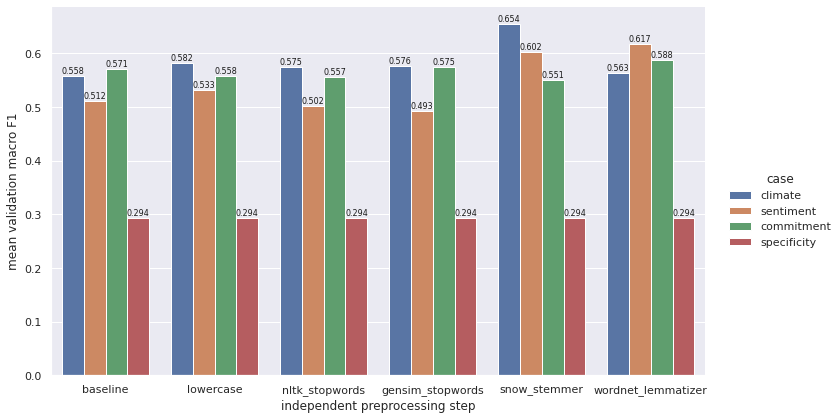

In [ ]:
ax = sns.catplot(
    data=df_cv, kind="bar",
    x="preprocessing", y="f1_macro", hue="case", height=6, aspect=1.7, 
)
ax.map(annotate_bars, fmt='.3f', fontsize=8, color='k')
ax.set_axis_labels("independent preprocessing step", "mean validation macro F1")

### Finding best thresholds and evaluating the test data

In [ ]:
from sklearn.metrics import f1_score

f1_marco_score = partial(f1_score, average='macro')

test_results = []
# After comparing the independent preprocessing method, we use NLTK_Stopwords; Snow_stemmer and lowercase    
self_defined_stopwords = set({'the', 'includ', 'in',  'also', 
              'use', 'this', 'bank', 'term', 'our', 'due', 'as', 'base', 
               'long', 'end', 'us', 'mine', 'it', 'oper', 
              'our', 'take', 'mine',  'metric', 'continu', 'team', 'two', 'member', 'across', 
              'kic', 'ghg', 'https', 'tilt','per',  'sector', 
              'next', 'three', 'ifc', 'one', 'www', 'line', 'for', 'due', 
              'sinc',  'bank', 'zero',  'four', 'all',  'with', 'save', 'mw','relat', 
              'time', 'higher','issu', 'these', 'model', 'mani', 'there', 'subject', 'etc',
              'becom', 'total', 'tonn', 'world', 'client',  'sourc', 'mix', 'around', 'medium', 
              'tool', 'phase', 'area', 'farm', 'ghg', 'level','net', 'unit', 'esg','show', 'page', 'offer', 
              'larg', 'usd', 'way', 'employe', 'within', 'countri','second', 'follow',
              'iag', 'short', 'sign', 'even', 'overal', 'five', 'home', 'these', 'made',  'largest',
              'local',  'cut', 'station', 'to', 'america','third', 'at', 'fire', 
              'without', 'give', 'make', 'mbank', 'peopl', 'asia', 'chain', 'research'})

self_defined_stopwords.update(nltk_stopwords) 
           
preprocessor = partial(preprocessor_fn, 
                       filters=[lambda x: x not in self_defined_stopwords],
                       mappers=[lambda x: x.lower(),
                                snow_stemmer.stem,
                               ])
best_estimators = {}
for y_col in ['climate', 'sentiment', 'commitment', 'specificity']:
    df = df_train[df_train[y_col].notnull()]
    X_train = df['text']
    y_train = df[y_col]
    
    parameters = {'thresholds': search_space(len(estimators[y_col]))}
    model = RuleBasedClassifier(estimators[y_col], preprocessor=preprocessor)
    

    cv = GridSearchCV(model, parameters, cv=5, scoring='f1_macro')
    cv.fit(X_train, y_train)
    best_estimators[y_col] = cv.best_estimator_

    #df = df_train[df_train[y_col].notnull()]
    #X_test = df['text']
    #y_test = df[y_col]
    y_pred = cv.best_estimator_.predict(X_train)
    score = f1_marco_score(y_train, y_pred)

    report = classification_report(y_train, y_pred)
    test_results.append((y_col, score, report, cv.best_params_['thresholds']))

df_results = pd.DataFrame(test_results, columns=['case', 'test_f1_macro', 'report', 'thresholds'])

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for report in df_results['report'].values:
    print(report)

              precision    recall  f1-score   support

          no       0.45      0.46      0.45        68
         yes       0.89      0.89      0.89       332

    accuracy                           0.81       400
   macro avg       0.67      0.67      0.67       400
weighted avg       0.81      0.81      0.81       400

              precision    recall  f1-score   support

     neutral       0.57      0.62      0.59       130
 opportunity       0.49      0.49      0.49        93
        risk       0.88      0.77      0.82       109

    accuracy                           0.64       332
   macro avg       0.65      0.63      0.64       332
weighted avg       0.65      0.64      0.64       332

              precision    recall  f1-score   support

          no       0.59      0.49      0.54       180
         yes       0.50      0.61      0.55       152

    accuracy                           0.54       332
   macro avg       0.55      0.55      0.54       332
weighted avg       0

In [ ]:
df_results

,case,test_f1_macro,report,thresholds
0,climate,0.669716,precision recall f1-score ...,"(0.1, 0.2)"
1,sentiment,0.636305,precision recall f1-score ...,"(0.0, 0.30000000000000004, 0.1)"
2,commitment,0.542102,precision recall f1-score ...,"(0.30000000000000004, 0.05)"
3,specificity,0.293617,precision recall f1-score ...,"(0.1, 0.0)"


Text(0, 0.5, 'test macro F1')

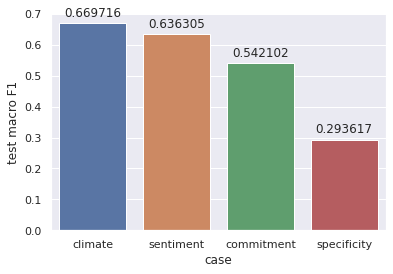

In [ ]:
ax = sns.barplot(data=df_results, x="case", y="test_f1_macro")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.6f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
ax.set_ylabel("test macro F1")

In [ ]:
#Using test dataset to predict
from sklearn.metrics import f1_score

f1_marco_score = partial(f1_score, average='macro')

test_results = []
# After comparing the independent preprocessing method, we use NLTK_Stopwords; Snow_stemmer and lowercase    
#'would', 
self_defined_stopwords = set({'the', 'includ', 'in', 'group', 'also', 'may' ,'share'
              'use', 'this', 'bank', 'could','term', 'our', 'due', 'as', 'base', 
              'current', 'long', 'end', 'us', 'mine', 'it', 'oper', 
              'our', 'take', 'mine',  'metric', 'continu', 'team', 'two', 'member', 'across', 
              'kic', 'ghg', 'https', 'tilt',  'million','per',  'sector', 
              'next', 'three', 'ifc', 'one', 'www', 'line', 'for', 'due', 
              'sinc',  'bank', 'zero',  'four', 'all',  'with', 'save', 'mw','relat', 
              'time', 'higher', 'long', 'issu', 'need', 'these', 'model', 'mani', 'there', 'subject', 'etc',
              'becom', 'total', 'tonn', 'world', 'client',  'sourc', 'mix', 'toward', 'around', 'medium', 
              'tool', 'phase', 'area', 'farm', 'ghg', 'level','billion','net', 'unit', 'esg','show', 'page', 'offer', 
              'larg', 'usd', 'way', 'employe', 'within', 'countri','second', 'follow',
              'iag', 'short', 'sign', 'even', 'overal', 'five', 'home', 'these', 'made',  'largest',
              'local',  'cut', 'station', 'to', 'america','third', 'at', 'fire', 
              'without', 'give', 'make', 'mbank', 'peopl', 'asia', 'chain', 'research'})

self_defined_stopwords.update(nltk_stopwords) 
           
preprocessor = partial(preprocessor_fn, 
                       filters=[lambda x: x not in self_defined_stopwords],
                       mappers=[lambda x: x.lower(),
                                snow_stemmer.stem,
                               ])
best_estimators = {}
for y_col in ['climate', 'sentiment', 'commitment', 'specificity']:
    df = df_train[df_train[y_col].notnull()]
    X_train = df['text']
    y_train = df[y_col]
    
    parameters = {'thresholds': search_space(len(estimators[y_col]))}
    model = RuleBasedClassifier(estimators[y_col], preprocessor=preprocessor)
    

    cv = GridSearchCV(model, parameters, cv=5, scoring='f1_macro')
    cv.fit(X_train, y_train)
    best_estimators[y_col] = cv.best_estimator_

    df = df_train[df_train[y_col].notnull()]
    X_test = df['text']
    y_test = df[y_col]
    y_pred = cv.best_estimator_.predict(X_train)
    score = f1_marco_score(y_train, y_pred)

    report = classification_report(y_train, y_pred)
    test_results.append((y_col, score, report, cv.best_params_['thresholds']))

df_results = pd.DataFrame(test_results, columns=['case', 'test_f1_macro', 'report', 'thresholds'])

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for report in df_results['report'].values:
    print(report)

              precision    recall  f1-score   support

          no       0.32      0.37      0.34        68
         yes       0.87      0.84      0.85       332

    accuracy                           0.76       400
   macro avg       0.59      0.60      0.60       400
weighted avg       0.77      0.76      0.76       400

              precision    recall  f1-score   support

     neutral       0.58      0.62      0.60       130
 opportunity       0.49      0.54      0.51        93
        risk       0.88      0.73      0.80       109

    accuracy                           0.63       332
   macro avg       0.65      0.63      0.64       332
weighted avg       0.65      0.63      0.64       332

              precision    recall  f1-score   support

          no       0.59      0.47      0.52       180
         yes       0.49      0.61      0.54       152

    accuracy                           0.53       332
   macro avg       0.54      0.54      0.53       332
weighted avg       0

In [ ]:
df_results

,case,test_f1_macro,report,thresholds
0,climate,0.595795,precision recall f1-score ...,"(0.2, 0.25)"
1,sentiment,0.635740,precision recall f1-score ...,"(0.0, 0.30000000000000004, 0.1)"
2,commitment,0.532925,precision recall f1-score ...,"(0.4, 0.05)"
3,specificity,0.293617,precision recall f1-score ...,"(0.1, 0.0)"
